In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import norm

In [3]:
def qq_plot(x):
    n = len(x)
    x = pd.Series(x)
    sample = ((x - x.mean())/x.std()).sort_values(ascending=True)
    theoretical = [norm.ppf((k+0.5)/n) for k in range(n)]
    plt.scatter(x=theoretical,y=sample)
    plt.axline((0,0), slope=1, color="darksalmon")
    plt.show()

In [4]:
# preprocessing
def normalise(df):
    return (df - df.mean())/df.std()

def boxcox_transform(df, lambdas=None):
    bc = pd.DataFrame()
    bc_lambdas = []
    for i, c in enumerate(df.columns):
        if lambdas is None:
            a, b = boxcox(df[c])
            bc_lambdas.append(b)
        else:
            a = boxcox(df[c], lmbda=lambdas[i])
        a = pd.Series(a, name=c, index=df.index)
        bc = pd.concat([bc, a], axis="columns")
    return bc, bc_lambdas

## 6.1

**The theory of IR spectroscopy holds that unique molecular structures absorb IR frequencies differently. In practice a spectrometer fires a series of IR frequencies into a sample material, and the device measures the absorbance of the sample at each individual frequency. This series of measurements creates a spectrum profile which can then be used to determine the chemical makeup of the sample material.**

**A Tecator Infratec Food and Feed Analyzer instrument was used to analyze 215 samples of meat across 100 frequencies. A sample of these frequency profiles is displayed in Fig. 6.20. In addition to an IR profile, analytical chemistry determined the percent content of water, fat, and protein for each sample.**

**(a) Load the data**

**(b) In this example the predictors are the measurements at the individual fre-quencies. Because the frequencies lie in a systematic order (850–1,050 nm), the predictors have a high degree of correlation. Hence, the data lie in a smaller dimension than the total number of predictors (100). Use PCA to determine the effective dimension of these data. What is the effective dimension?**

Variance explained by first 10 components of PCA\
0 - 26.1271\
1 - 0.2385\
2 - 0.0784\
3 - 0.0302\
4 - 0.0015\
5 - 0.0007\
6 - 0.0002\
7 - 0.0001\
8 - 0.0000\
9 - 0.0000

Used boxcox transform and normalisation to reduce skewness. Variation explained remains same ratio.

The effective dimention of PCA is 1.

**(c) Split the data into a training and a test set, pre-process the data, and build each variety of models described in this chapter. For those models with tuning parameters, what are the optimal values of the tuning parameter(s)?**

**(d) Which model has the best predictive ability? Is any model significantly better or worse than the others?**

**(e) Explain which model you would use for predicting the fat content of a sample.**

In [5]:
# Reading in data

absorb = pd.read_csv("/home/roger/code/applied-predictive-modeling/data/absorb.csv", index_col="id", header=0)
endpoints = pd.read_csv("/home/roger/code/applied-predictive-modeling/data/endpoints.csv", index_col="id", header=0)
endpoints=endpoints.rename(columns=
    {"V2":"fat"})
absorb = pd.concat([absorb, endpoints[["fat"]]], axis="columns")

In [6]:
pca = PCA()
pca.fit(absorb.drop(columns="fat"))

PCA()

In [7]:
print("Total:", pca.explained_variance_.sum())
for i, var in enumerate(pca.explained_variance_[:10]):
    print(i, f"{var:.4f}")

Total: 26.476848832131623
0 26.1271
1 0.2385
2 0.0784
3 0.0302
4 0.0015
5 0.0007
6 0.0002
7 0.0001
8 0.0000
9 0.0000


In [8]:
absorb_n = (absorb - absorb.mean())/absorb.std()
absorb_n["fat"] = absorb["fat"]

In [9]:
pca_n = PCA()
pca_n.fit(absorb_n.drop(columns="fat"))

PCA()

In [10]:
for i, var in enumerate(pca.explained_variance_[:10]):
    print(i, f"{var:.4f}")

0 26.1271
1 0.2385
2 0.0784
3 0.0302
4 0.0015
5 0.0007
6 0.0002
7 0.0001
8 0.0000
9 0.0000


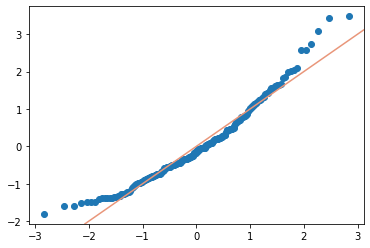

In [11]:
# qq plot for untransformed variable
qq_plot(absorb_n["V1"])

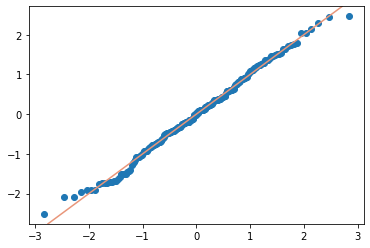

In [12]:
# qq plot for box cox transformed variable
x_bc, l = boxcox(absorb["V1"])
qq_plot(x_bc)

In [13]:
# use boxcox to transform all variables, what effect does this have on PCA?

absorb_bc = pd.DataFrame()
bc_lambdas = []
for c in absorb.columns:
    a, b = boxcox(absorb[c])
    a = pd.Series(a, name=c, index=absorb.index)
    absorb_bc = pd.concat([absorb_bc, a], axis="columns")
    bc_lambdas.append(b)
absorb_bc["fat"] = absorb["fat"]

In [14]:
pca_bc = PCA()
pca_bc.fit(absorb_bc.drop(columns="fat"))

PCA()

In [15]:
for i, var in enumerate(pca_bc.explained_variance_[:10]):
    print(i, f"{var:.4f}")

0 0.1585
1 0.0012
2 0.0004
3 0.0001
4 0.0000
5 0.0000
6 0.0000
7 0.0000
8 0.0000
9 0.0000


In [16]:
# With/without standardisation + boxcox
# Ordinary Least Squares
# PCA
# PLS
# squared regularisation
# abs regularisation

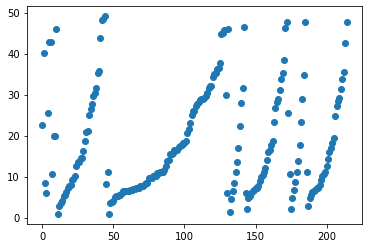

In [17]:
# checking for patterns in target variable
# looks like data is not randomised
plt.scatter(x=range(len(absorb["fat"])), y=absorb["fat"])
plt.show()

In [18]:
# training/validation/test
no_transform = {}

no_transform["train_val"], no_transform["test"] = train_test_split(absorb, test_size=0.2)
no_transform["train"], no_transform["val"] = train_test_split(no_transform["train_val"], test_size=0.25)

y = {}
for key in no_transform:
    y[key] = no_transform[key]["fat"]
    no_transform[key] = no_transform[key].drop(columns="fat")

In [19]:
normalised = {}
for key in no_transform:
    normalised[key] = normalise(no_transform[key])

bc_transformed = {}
bc_transformed["train"], lambdas = boxcox_transform(no_transform["train"])
for key in [e for e in no_transform if e != "train"]:
    bc_transformed[key], _ = boxcox_transform(no_transform[key], lambdas)

In [20]:
# Ordinary Least Squares
ols_no_preprocessing = linear_model.LinearRegression()
ols_normalise = linear_model.LinearRegression(normalize=True)
ols_boxcox = linear_model.LinearRegression(normalize=True)

In [21]:
# Training
ols_no_preprocessing.fit(X=no_transform["train_val"], y=y["train_val"])
ols_normalise.fit(X=no_transform["train_val"], y=y["train_val"])
ols_boxcox.fit(X=bc_transformed["train_val"], y=y["train_val"])

LinearRegression(normalize=True)

In [22]:
# Testing
print(f'Ordinary Least Squares without preprocessing R2: {ols_no_preprocessing.score(X=no_transform["test"], y=y["test"]):.4f}')
print(f'Ordinary Least Squares with normalisation R2: {ols_normalise.score(X=no_transform["test"], y=y["test"]):.4f}')

# boxcox transform
print(f'Ordinary Least Squares with norm & boxcox R2: {ols_boxcox.score(X=bc_transformed["test"], y=y["test"]):.4f}')

Ordinary Least Squares without preprocessing R2: 0.9642
Ordinary Least Squares with normalisation R2: 0.9642
Ordinary Least Squares with norm & boxcox R2: 0.9712


In [44]:
pca_scores = []

for n_components in range(1, min(bc_transformed["train"].shape)-1):
    pca_x = {}
    pca = PCA(n_components=n_components)
    ols_pca = linear_model.LinearRegression()

    pca_x["train"] = pca.fit_transform(bc_transformed["train"])
    pca_x["val"] = pca.transform(bc_transformed["val"])
    pca_x["test"] = pca.transform(bc_transformed["test"])

    ols_pca.fit(X=pca_x["train"], y=y["train"])
    pca_scores.append(ols_pca.score(X=pca_x["val"], y=y["val"]))
    
n = pca_scores.index(max(pca_scores))+1
pca_final = PCA(n_components=n)
pca_x["train_val"] = pca_final.fit_transform(bc_transformed["train_val"])
pca_x["test"] = pca_final.transform(bc_transformed["test"])
ols_pca.fit(pca_x["train_val"], y["train_val"])

print(f'pca test score {ols_pca.score(pca_x["test"], y["test"]):.4f}')

pca test score 0.9726


In [47]:
# PLS
# Loop through top X components
# Fit regression
# Find R2 on test set
# Graph
pls_scores = []

for n_components in range(1, min(bc_transformed["train"].shape)-1):
    pls = PLSRegression(n_components=n_components)
    ols_pls = linear_model.LinearRegression()

    pls_x = {}
    pls.fit(bc_transformed["train"], y["train"])
    pls_scores.append(pls.score(X=bc_transformed["val"], y=y["val"]))

# Select number of components with highest R2 score
# Fit regression on training and validation set
# Score on test set
n = pls_scores.index(max(pls_scores))+1
pls_final = PLSRegression(n_components=n)
pls.fit(bc_transformed["train_val"], y["train_val"])
print(f'pls test score {pls.score(X=bc_transformed["test"], y=y["test"]):.4f}')

pls test score 0.9712


In [38]:
# Penalised Regression

alphas = []
scores_l1 = []
scores_l2 = []
for i in range(-30, 0):
    alpha = 10**(i/4)
    alphas.append(alpha)
    ols_l1 = linear_model.Lasso(alpha=alpha, max_iter=10_000)
    ols_l2 = linear_model.Ridge(alpha=alpha, max_iter=10_000)
    ols_l1.fit(bc_transformed["train"], y["train"])
    ols_l2.fit(bc_transformed["train"], y["train"])
    scores_l1.append(ols_l1.score(bc_transformed["val"], y["val"]))
    scores_l2.append(ols_l2.score(bc_transformed["val"], y["val"]))

alpha_l1 = alphas[scores_l1.index(max(scores_l1))]
alpha_l2 = alphas[scores_l2.index(max(scores_l2))]
ols_l1 = linear_model.Lasso(alpha=alpha_l1, max_iter=10_000)
ols_l2 = linear_model.Ridge(alpha=alpha_l2, max_iter=10_000)
ols_l1.fit(bc_transformed["train_val"], y["train_val"])
ols_l2.fit(bc_transformed["train_val"], y["train_val"])
print(f'l1 regularisation: {ols_l1.score(bc_transformed["test"], y["test"])}')
print(f'l2 regularisation: {ols_l2.score(bc_transformed["test"], y["test"])}')

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.1725853986227, tolerance: 2.0810515503875973
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.1240973263663, tolerance: 2.0810515503875973
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.0377295259171, tolerance: 2.0810515503875973
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

l1 regularisation: 0.9473306945946155
l2 regularisation: 0.9798137847853452


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.19417924504819, tolerance: 2.7109170406976744
  model = cd_fast.enet_coordinate_descent(


In [71]:
# Boostrapping R2 with different train/val/test splits
# Creating split
train_val, test = train_test_split(absorb, test_size=0.2)
train, val = train_test_split(train_val, test_size=0.25)
ds = {}
ds["x_train"] = train.drop(columns="fat")
ds["x_val"] = val.drop(columns="fat")
ds["x_train_val"] = train_val.drop(columns="fat")
ds["x_test"] = test.drop(columns="fat")
ds["y_train"] = train["fat"]
ds["y_val"] = val["fat"]
ds["y_train_val"] = train_val["fat"]
ds["y_test"] = test["fat"]

In [78]:
def ols(ds):
    ols = linear_model.LinearRegression()
    ols.fit(X=ds["x_train_val"], y=ds["y_train_val"])
    return ols.score(X=ds["x_test"], y=ds["y_test"])

In [85]:
ols(ds)

0.8286571542245831

In [83]:
def ols_bc(ds):
    ols_boxcox = linear_model.LinearRegression(normalize=True)
    train_val_bc, lambdas = boxcox_transform(ds["x_train_val"])
    ols_boxcox.fit(X=train_val_bc, y=ds["y_train_val"])
    test_bc, _ = boxcox_transform(ds["x_test"], lambdas=lambdas)
    return ols_boxcox.score(X=test_bc, y=ds["y_test"])

In [84]:
ols_bc(ds)

0.8994884961477142

In [91]:
def pca(ds):
    pca_scores = []

    for n_components in range(1, min(ds["x_train"].shape)-1):
        pca_x = {}
        pca = PCA(n_components=n_components)
        ols_pca = linear_model.LinearRegression()

        pca_x["train"] = pca.fit_transform(ds["x_train"])
        pca_x["val"] = pca.transform(ds["x_val"])
        pca_x["test"] = pca.transform(ds["x_test"])

        ols_pca.fit(X=pca_x["train"], y=ds["y_train"])
        pca_scores.append(ols_pca.score(X=pca_x["val"], y=ds["y_val"]))

    n = pca_scores.index(max(pca_scores))+1
    pca_final = PCA(n_components=n)
    pca_x["train_val"] = pca_final.fit_transform(ds["x_train_val"])
    pca_x["test"] = pca_final.transform(ds["x_test"])
    ols_pca.fit(pca_x["train_val"], ds["y_train_val"])

    return ols_pca.score(pca_x["test"], ds["y_test"])

In [92]:
pca(ds)

0.9539668560318305

In [98]:
def pls(ds):
    pls_scores = []

    for n_components in range(1, min(ds["x_train"].shape)-1):
        pls = PLSRegression(n_components=n_components)
        ols_pls = linear_model.LinearRegression()

        pls_x = {}
        pls.fit(ds["x_train"], ds["y_train"])
        pls_scores.append(pls.score(X=ds["x_val"], y=ds["y_val"]))

    # Select number of components with highest R2 score
    # Fit regression on training and validation set
    # Score on test set
    n = pls_scores.index(max(pls_scores))+1
    pls_final = PLSRegression(n_components=n)
    pls_final.fit(ds["x_train_val"], ds["y_train_val"])
    return pls_final.score(X=ds["x_test"], y=ds["y_test"])

In [99]:
pls(ds)

0.9612861674269154

In [102]:
def penalised_regression(ds, model):
    ds_bc = {}
    ds_bc["x_train"], lambdas = boxcox_transform(ds["x_train"])
    ds_bc["x_val"], _ = boxcox_transform(ds["x_val"], lambdas=lambdas)
    ds_bc["x_train_val"], lambdas = boxcox_transform(ds["x_train_val"])
    ds_bc["x_test"], _ = boxcox_transform(ds["x_test"], lambdas=lambdas)
    
    scores = []
    alphas = [10**(i/4) for i in range(-30, 0)]
    for alpha in alphas:
        penalised_reg = model(alpha=alpha, max_iter=10_000)
        penalised_reg.fit(ds_bc["x_train"], ds["y_train"])
        scores.append(penalised_reg.score(ds_bc["x_val"], ds["y_val"]))

    best_alpha = alphas[scores.index(max(scores))]
    final_model = model(alpha=best_alpha, max_iter=10_000)
    final_model.fit(ds_bc["x_train_val"], ds["y_train_val"])
    return final_model.score(ds_bc["x_test"], ds["y_test"])


In [103]:
print(penalised_regression(ds, linear_model.Lasso))
print(penalised_regression(ds, linear_model.Ridge))

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692.3234310010625, tolerance: 2.106432372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692.2376646568248, tolerance: 2.106432372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692.0846494193371, tolerance: 2.106432372093024
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

0.9274682221562778
0.9663646876033632


In [128]:
trials = 100
results = pd.DataFrame()

for i in range(trials):
    train_val, test = train_test_split(absorb, test_size=0.2)
    train, val = train_test_split(train_val, test_size=0.25)
    ds = {}
    ds["x_train"] = train.drop(columns="fat")
    ds["x_val"] = val.drop(columns="fat")
    ds["x_train_val"] = train_val.drop(columns="fat")
    ds["x_test"] = test.drop(columns="fat")
    ds["y_train"] = train["fat"]
    ds["y_val"] = val["fat"]
    ds["y_train_val"] = train_val["fat"]
    ds["y_test"] = test["fat"]

    results = results.append({
        "ols":ols(ds),
        "ols_bc": ols_bc(ds),
        "pca": pca(ds),
        "pls": pls(ds),
        "l1": penalised_regression(ds, linear_model.Lasso),
        "l2": penalised_regression(ds, linear_model.Ridge)
    }, ignore_index=True)
    print(i)

/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.2951431282963, tolerance: 1.9087202325581392
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.3058252726671, tolerance: 1.9087202325581392
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.32477163020775, tolerance: 1.9087202325581392
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

0


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.0418846608923, tolerance: 1.8621189922480623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.0321384757715, tolerance: 1.8621189922480623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.0147897594077, tolerance: 1.8621189922480623
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

1


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.5986394624487, tolerance: 2.0496498759689925
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.6166790693182, tolerance: 2.0496498759689925
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.648551677832, tolerance: 2.0496498759689925
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

2


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.8253413180677, tolerance: 2.3221912248062018
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.8205911122141, tolerance: 2.3221912248062018
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.8120947558123, tolerance: 2.3221912248062018
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

3


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.4200731967087, tolerance: 1.933817550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.4266384846979, tolerance: 1.933817550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.4382497874465, tolerance: 1.933817550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

4


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.1245130710605, tolerance: 1.877119596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.0885809743353, tolerance: 1.877119596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.0245751240354, tolerance: 1.877119596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

5


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.3674551565501, tolerance: 1.9652709302325582
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.3042571936596, tolerance: 1.9652709302325582
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.1915058898423, tolerance: 1.9652709302325582
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

6


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.68484170998636, tolerance: 2.262593596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.6670499614712, tolerance: 2.262593596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.63526607900553, tolerance: 2.262593596899225
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

7


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.060035679535, tolerance: 1.9473529922480624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.0413176274534, tolerance: 1.9473529922480624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.007911959525, tolerance: 1.9473529922480624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

8


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.066868882893, tolerance: 2.114724992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.08836125981895, tolerance: 2.114724992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454.1265526819596, tolerance: 2.114724992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

9


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7794322487994, tolerance: 1.9097062015503878
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7613168954567, tolerance: 1.9097062015503878
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7290391873124, tolerance: 1.9097062015503878
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

10


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.1558355979388, tolerance: 2.1098781550387598
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.1630878383759, tolerance: 2.1098781550387598
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.1757867898754, tolerance: 2.1098781550387598
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

11


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.55796325784115, tolerance: 1.8713953953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.5521854200788, tolerance: 1.8713953953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.5418756918002, tolerance: 1.8713953953488374
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

12


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.8439284880793, tolerance: 2.1851883255813958
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.8085490830204, tolerance: 2.1851883255813958
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 568.7454566490072, tolerance: 2.1851883255813958
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

13


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529.7584885969245, tolerance: 2.1565235813953487
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529.7644535620334, tolerance: 2.1565235813953487
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529.7750333425568, tolerance: 2.1565235813953487
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

14


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 635.6762919528313, tolerance: 2.246492387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 635.5968850127027, tolerance: 2.246492387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 635.4552172993112, tolerance: 2.246492387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

15


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.7763934992288, tolerance: 2.2358848372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.7467144682421, tolerance: 2.2358848372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.69377171886197, tolerance: 2.2358848372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

16


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.3280197970333, tolerance: 2.256274666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.288186154516, tolerance: 2.256274666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.2176503303936, tolerance: 2.256274666666667
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

17


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.7141203172235, tolerance: 2.2444955968992253
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.706318808122, tolerance: 2.2444955968992253
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.6923535306953, tolerance: 2.2444955968992253
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

18


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.7825573513753, tolerance: 2.444151550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.787509019582, tolerance: 2.444151550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.7961215327393, tolerance: 2.444151550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

19


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462.28146554836616, tolerance: 1.9036232248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462.2917885906992, tolerance: 1.9036232248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462.3101010117919, tolerance: 1.9036232248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

20


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.3215220672913, tolerance: 2.1711748992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.2803655055549, tolerance: 2.1711748992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.2070314458899, tolerance: 2.1711748992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

21


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.94438580563207, tolerance: 1.769501550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.93638502133405, tolerance: 1.769501550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484.9220829512467, tolerance: 1.769501550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

22


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.4810734365682, tolerance: 2.1752856899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.4717961187215, tolerance: 2.1752856899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.4552356980901, tolerance: 2.1752856899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

23


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.2598547881911, tolerance: 2.015657550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.245461237193, tolerance: 2.015657550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535.2195097022337, tolerance: 2.015657550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

24


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.6536343679282, tolerance: 2.221855550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.6393061275263, tolerance: 2.221855550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543.6136652405676, tolerance: 2.221855550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

25


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403.0450392698079, tolerance: 1.961559488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403.05184863768, tolerance: 1.961559488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403.0639333353762, tolerance: 1.961559488372093
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

26


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.10772194729884, tolerance: 2.250718899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.1048671548032, tolerance: 2.250718899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.09972824662054, tolerance: 2.250718899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

27


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.3821308355019, tolerance: 1.9716776899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.3625297008038, tolerance: 1.9716776899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.32765056993446, tolerance: 1.9716776899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

28


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.8881722248096, tolerance: 2.0869340155038762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.8786339430502, tolerance: 2.0869340155038762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.8616369734552, tolerance: 2.0869340155038762
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

29


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.4560383644547, tolerance: 2.0628772093023255
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.4146037741037, tolerance: 2.0628772093023255
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549.3407986104356, tolerance: 2.0628772093023255
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

30


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.7414340924493, tolerance: 1.5449894883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.7414797850468, tolerance: 1.5449894883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 474.741579960567, tolerance: 1.5449894883720932
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

31


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.97128938654583, tolerance: 1.9887263875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.9712384156042, tolerance: 1.9887263875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.9711059607244, tolerance: 1.9887263875968995
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

32


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371.74394731242035, tolerance: 1.9112202480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371.7446500855044, tolerance: 1.9112202480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371.7459103316369, tolerance: 1.9112202480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

33


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.2057266562317, tolerance: 2.2805287596899224
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.120172675325, tolerance: 2.2805287596899224
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 649.9678014907523, tolerance: 2.2805287596899224
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

34


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.5520690732632, tolerance: 2.127828093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.51265844275, tolerance: 2.127828093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 592.4424103937665, tolerance: 2.127828093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

35


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.0802751066932, tolerance: 2.1191879224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.0795752883568, tolerance: 2.1191879224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511.07830174459133, tolerance: 2.1191879224806205
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

36


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.9281892903884, tolerance: 2.0083448837209303
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.9082796797121, tolerance: 2.0083448837209303
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 539.8728351605894, tolerance: 2.0083448837209303
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

37


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.76163487089343, tolerance: 1.9866930232558138
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.73261764680797, tolerance: 1.9866930232558138
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463.6807398783612, tolerance: 1.9866930232558138
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

38


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 421.0031586543987, tolerance: 1.8662172248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.996175132397, tolerance: 1.8662172248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420.98377178458384, tolerance: 1.8662172248062017
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

39


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.4651238675552, tolerance: 2.216702992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.4379015306663, tolerance: 2.216702992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 608.389322041062, tolerance: 2.216702992248062
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

40


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.6270476546666, tolerance: 2.080878620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.6257980109654, tolerance: 2.080878620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.6234681997183, tolerance: 2.080878620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

41


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.9128292464695, tolerance: 2.117549581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.9316526987529, tolerance: 2.117549581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.9650963866945, tolerance: 2.117549581395349
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

42


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.1999165640673, tolerance: 2.202804620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.1835573043978, tolerance: 2.202804620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.1542380492721, tolerance: 2.202804620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

43


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.456902097748, tolerance: 2.165268480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.4584527965077, tolerance: 2.165268480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.46114477731885, tolerance: 2.165268480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

44


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.6418139203325, tolerance: 1.8400613023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.6490704468666, tolerance: 1.8400613023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.6618272254233, tolerance: 1.8400613023255814
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

45


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.1707974908654, tolerance: 1.9358367596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.1603701504132, tolerance: 1.9358367596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.141614959259, tolerance: 1.9358367596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

46


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644.1243611863458, tolerance: 2.228626093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644.1225424890662, tolerance: 2.228626093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 644.1192741797686, tolerance: 2.228626093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

47


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.09853540046464, tolerance: 1.9996547596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.0972172170002, tolerance: 1.9996547596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.09486259316753, tolerance: 1.9996547596899226
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

48


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.8186120249693, tolerance: 2.1097068992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.8202012883553, tolerance: 2.1097068992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.8229789840149, tolerance: 2.1097068992248063
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

49


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422.31521648240476, tolerance: 2.055770201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422.3160181288141, tolerance: 2.055770201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422.31741308009225, tolerance: 2.055770201550388
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

50


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.34278340362744, tolerance: 2.12074703875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.3384809658907, tolerance: 2.12074703875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481.33027158763537, tolerance: 2.12074703875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

51


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 514.9117387040351, tolerance: 2.111619209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 514.894163518383, tolerance: 2.111619209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 514.8628449864991, tolerance: 2.111619209302326
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

52


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.3535100707343, tolerance: 2.233372372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.3329267112252, tolerance: 2.233372372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 589.2962524096121, tolerance: 2.233372372093023
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

53


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.0645398928123, tolerance: 2.051652759689923
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.0627554051049, tolerance: 2.051652759689923
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 537.0595710409056, tolerance: 2.051652759689923
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

54


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.9896831888457, tolerance: 2.049688899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.9400235670329, tolerance: 2.049688899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.8515994236291, tolerance: 2.049688899224806
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

55


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 772.7805543122199, tolerance: 2.1334362480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 772.7770842927114, tolerance: 2.1334362480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 772.7708786771934, tolerance: 2.1334362480620155
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

56


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.5992354918557, tolerance: 2.1771516899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.5653817902994, tolerance: 2.1771516899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487.50500892831707, tolerance: 2.1771516899224808
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

57


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.66127174907206, tolerance: 2.287164387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.66274560958357, tolerance: 2.287164387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.66537144041985, tolerance: 2.287164387596899
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

58


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.6644747047427, tolerance: 2.13300015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.6537801786533, tolerance: 2.13300015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.6346987016428, tolerance: 2.13300015503876
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

59


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.0951417152078, tolerance: 1.9742222325581396
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.0961489320671, tolerance: 1.9742222325581396
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.09788371408064, tolerance: 1.9742222325581396
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

60


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.8466134275748, tolerance: 2.2774528372093026
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.8275484991218, tolerance: 2.2774528372093026
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.7933138482936, tolerance: 2.2774528372093026
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

61


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.4763621975512, tolerance: 2.0291868062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.4649692418615, tolerance: 2.0291868062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 521.4445506222664, tolerance: 2.0291868062015506
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

62


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.0537524357246, tolerance: 2.381797395348837
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.043245274149, tolerance: 2.381797395348837
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 581.0244631297535, tolerance: 2.381797395348837
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

63


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 530.4166628599371, tolerance: 2.2329483720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 530.4141366299094, tolerance: 2.2329483720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 530.4096011549503, tolerance: 2.2329483720930234
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

64


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622.7365444808614, tolerance: 1.9865809922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622.7289619707004, tolerance: 1.9865809922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622.7154206919488, tolerance: 1.9865809922480622
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

65


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499.28425126263716, tolerance: 1.930249550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499.28131341560584, tolerance: 1.930249550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499.27600459141394, tolerance: 1.930249550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

66


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.6759966486635, tolerance: 2.1167893488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.649155829803, tolerance: 2.1167893488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.6013064555078, tolerance: 2.1167893488372096
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

67


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.6060319898246, tolerance: 1.9738699224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.6028362131472, tolerance: 1.9738699224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.5970533856381, tolerance: 1.9738699224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

68


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.5991684715536, tolerance: 2.021005534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.556554560399, tolerance: 2.021005534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.4808210774047, tolerance: 2.021005534883721
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

69


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 612.7925091503482, tolerance: 1.906948062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 612.7967201101081, tolerance: 1.906948062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 612.8040786334323, tolerance: 1.906948062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

70


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.8462125613498, tolerance: 2.32378
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.8307592512917, tolerance: 2.32378
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.803207224826, tolerance: 2.32378
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: 

71


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.2421987987748, tolerance: 2.301241720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.2278004279395, tolerance: 2.301241720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.2021881370472, tolerance: 2.301241720930233
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

72


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.1585024180585, tolerance: 2.2707668062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.1152560898018, tolerance: 2.2707668062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434.0381452304533, tolerance: 2.2707668062015505
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

73


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.5379886470632, tolerance: 1.8926256899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.5533166575016, tolerance: 1.8926256899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489.58053656959834, tolerance: 1.8926256899224807
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_d

74


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584.6424463278063, tolerance: 1.960346
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584.6184937028011, tolerance: 1.960346
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584.5757809074096, tolerance: 1.960346
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarni

75


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.7597997669895, tolerance: 2.3145255038759696
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.7439858981612, tolerance: 2.3145255038759696
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.7154539791693, tolerance: 2.3145255038759696
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

76


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.5201401834652, tolerance: 2.0399623255813952
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.5068046492629, tolerance: 2.0399623255813952
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.4830547250617, tolerance: 2.0399623255813952
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

77


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.8754352952774, tolerance: 2.0105710387596907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.8670398853421, tolerance: 2.0105710387596907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.8520671687562, tolerance: 2.0105710387596907
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

78


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.12228091033774, tolerance: 2.1792915503875974
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.1066031351044, tolerance: 2.1792915503875974
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.07866360029857, tolerance: 2.1792915503875974
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_

79


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.7395777819808, tolerance: 1.9763262325581397
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.715595250908, tolerance: 1.9763262325581397
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.672763784615, tolerance: 1.9763262325581397
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

80


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.7879098349476, tolerance: 2.0788415038759696
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.7744632903895, tolerance: 2.0788415038759696
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.7502888937745, tolerance: 2.0788415038759696
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

81


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.8526516858444, tolerance: 2.0771952248062013
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.8522228823736, tolerance: 2.0771952248062013
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.851444031673, tolerance: 2.0771952248062013
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

82


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.8224109595045, tolerance: 1.9033823720930232
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.8022441191043, tolerance: 1.9033823720930232
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.7662104576374, tolerance: 1.9033823720930232
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

83


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.10264723026, tolerance: 1.969215550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.1024662752866, tolerance: 1.969215550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.102057162844, tolerance: 1.969215550387597
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

84


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.5249031657175, tolerance: 2.2344443875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.4787817101851, tolerance: 2.2344443875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.396533399398, tolerance: 2.2344443875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:5

85


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431.03649212321017, tolerance: 2.18779903875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431.04282462268884, tolerance: 2.18779903875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431.0540408003659, tolerance: 2.18779903875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descen

86


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.6309211462813, tolerance: 1.9863744806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.6009301337307, tolerance: 1.9863744806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.5474616492244, tolerance: 1.9863744806201555
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

87


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.2634480940267, tolerance: 2.020651968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.27121030079815, tolerance: 2.020651968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 497.2849525558975, tolerance: 2.020651968992248
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

88


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.6347417847942, tolerance: 2.0377452558139537
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.6387358374109, tolerance: 2.0377452558139537
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464.645848191937, tolerance: 2.0377452558139537
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

89


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.4201935732272, tolerance: 2.1728179689922484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.4071653734081, tolerance: 2.1728179689922484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 585.3839902113227, tolerance: 2.1728179689922484
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_de

90


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.2419452886819, tolerance: 1.91624703875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.2074802228761, tolerance: 1.91624703875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.1462081809374, tolerance: 1.91624703875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

91


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.623951953383, tolerance: 1.9940948062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.6515116453188, tolerance: 1.9940948062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.7002954857201, tolerance: 1.9940948062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

92


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.2677691052821, tolerance: 1.841614062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.2596375025938, tolerance: 1.841614062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.2451187825538, tolerance: 1.841614062015504
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

93


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.4549471456105, tolerance: 2.1444813023255813
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.455177260919, tolerance: 2.1444813023255813
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 600.4555652598276, tolerance: 2.1444813023255813
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

94


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.5007711894647, tolerance: 1.848847224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.4783478722818, tolerance: 1.848847224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523.4383892614703, tolerance: 1.848847224806202
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

95


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577.5510392057422, tolerance: 1.944822620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577.5296235861662, tolerance: 1.944822620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577.4914689479103, tolerance: 1.944822620155039
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

96


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.9304210506767, tolerance: 2.186236093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.9318637787777, tolerance: 2.186236093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590.9343771362835, tolerance: 2.186236093023256
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desce

97


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.6960379436105, tolerance: 2.31596103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.6944296717642, tolerance: 2.31596103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541.6915454818245, tolerance: 2.31596103875969
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.

98


/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.8039941574198, tolerance: 2.1160069922480624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.8022779021996, tolerance: 2.1160069922480624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 554.799053417721, tolerance: 2.1160069922480624
  model = cd_fast.enet_coordinate_descent(
/home/roger/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_des

99


In [121]:
results = pd.DataFrame(columns=["ols", "ols_bc", "pca", "pls", "l1", "l2"])
results.append(d, ignore_index=True)

,ols,ols_bc,pca,pls,l1,l2
0,0.973752,0.979888,0.977389,0.979892,0.937251,0.987394


In [130]:
results.describe()

,ols,ols_bc,pca,pls,l1,l2
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.902687,0.966019,0.942013,0.944806,0.935174,0.981575
std,0.066153,0.016933,0.056986,0.050553,0.018989,0.007771
min,0.626412,0.906850,0.626056,0.579821,0.874506,0.949282
25%,0.870753,0.959010,0.942429,0.938958,0.925883,0.977910
50%,0.913085,0.968699,0.959523,0.957550,0.936525,0.983435
75%,0.954266,0.978071,0.968250,0.967118,0.949496,0.986997
max,0.979217,0.988367,0.981727,0.987335,0.968094,0.993990
